In [279]:
import os
import pandas as pd
import numpy as np
import json
import matplotlib as plot
from matplotlib import pyplot as plt
import folium
import seaborn as sns
import warnings
warnings.filterwarnings(action="ignore")

In [286]:
# to change the os path
os.chdir("C:\A-Personal\AI2\CourseaProjects\DA-1\Class3-Week4")
df_Full = pd.read_csv("traffic-collision-data-from-2010-to-present.csv")

# 1- Data cleaning

In [274]:
print("the rows and cols count are ",df_Full.shape)
df_Full.head(1)

the rows and cols count are  (476337, 24)


,DR Number,Date Reported,Date Occurred,Time Occurred,Area ID,Area Name,Reporting District,Crime Code,Crime Code Description,MO Codes,...,Premise Description,Address,Cross Street,Location,Zip Codes,Census Tracts,Precinct Boundaries,LA Specific Plans,Council Districts,Neighborhood Councils (Certified)
0,191216137,2019-06-15T00:00:00.000,2019-06-15T00:00:00.000,330,12,77th Street,1203,997,TRAFFIC COLLISION,4025 3028 3101 3006 3030,...,STREET,52ND ST,WESTERN AV,"{'longitude': '-118.3089', 'latitude': '33.995...",24027.0,742.0,1049.0,7.0,14.0,35.0


### 1.1- Base on the defination of db dictionary from https://www.kaggle.com/cityofLA/los-angeles-traffic-collision-data, should drop below columns base due to:
- All crime codes and crime code descriptions are same in the dataset
- No description about Census Tracts , Precinct Boundaries , LA Specific Plans , Council Districts , Neighborhood Councils

In [287]:
df_Full = df_Full.drop(
    ["Crime Code","Crime Code Description","Census Tracts","Precinct Boundaries","LA Specific Plans",
     "Council Districts","Neighborhood Councils (Certified)","Zip Codes"],axis=1)

In [288]:
print(df_Full.columns)

# reset the column names
df_Full.columns = ['DR_Number', 'Date_Reported', 'Date_Occurred', 'Time_Occurred',
       'Area_ID', 'Area_Name', 'Reporting_District', 'MO_Codes', 'Victim_Age',
       'Victim_Sex', 'Victim_Descent', 'Premise_Code', 'Premise_Description',
       'Address', 'Cross_Street', 'Location']
df_Full.head(1)

Index(['DR Number', 'Date Reported', 'Date Occurred', 'Time Occurred',
       'Area ID', 'Area Name', 'Reporting District', 'MO Codes', 'Victim Age',
       'Victim Sex', 'Victim Descent', 'Premise Code', 'Premise Description',
       'Address', 'Cross Street', 'Location'],
      dtype='object')


,DR_Number,Date_Reported,Date_Occurred,Time_Occurred,Area_ID,Area_Name,Reporting_District,MO_Codes,Victim_Age,Victim_Sex,Victim_Descent,Premise_Code,Premise_Description,Address,Cross_Street,Location
0,191216137,2019-06-15T00:00:00.000,2019-06-15T00:00:00.000,330,12,77th Street,1203,4025 3028 3101 3006 3030,39.0,F,B,101.0,STREET,52ND ST,WESTERN AV,"{'longitude': '-118.3089', 'latitude': '33.995..."


### 1.2- For more convenience to aggregate the data by datetime add below new fields
- Reported year/month/day
- Occur year/month/day
- Classify the time period by every 3 hours

In [291]:
# add columns for datetime split
df_Full["Report_Year"] = df_Full["Date_Reported"].str[:4]
df_Full["Report_Month"] = df_Full["Date_Reported"].str[5:7]
df_Full["Report_Day"] = df_Full["Date_Reported"].str[8:10]

df_Full["Occur_Year"] = df_Full["Date_Occurred"].str[:4]
df_Full["Occur_Month"] = df_Full["Date_Occurred"].str[5:7]
df_Full["Occur_Day"] = df_Full["Date_Occurred"].str[8:10]

df_Full["Date_Reported"] = pd.to_datetime(df_Full["Date_Reported"])
df_Full["Date_Occurred"] = pd.to_datetime(df_Full["Date_Occurred"])
df_Full["WeekDay"] = df_Full.Date_Occurred.dt.dayofweek

df_Full[["Date_Reported","Date_Occurred","Report_Year","Report_Month","Report_Day"]].head()

,Date_Reported,Date_Occurred,Report_Year,Report_Month,Report_Day
0,2019-06-15,2019-06-15,2019,06,15
1,2019-06-15,2019-06-15,2019,06,15
2,2019-06-15,2019-06-15,2019,06,15
3,2019-06-15,2019-06-15,2019,06,15
4,2019-06-15,2019-06-15,2019,06,15


In [293]:
# classification the time period
# To seperate the timing to 8 group:
# - Mid night(0000-0300] : 1
# - Early morning(0300-0600] : 2
# - Morning(0600-0900] : 3
# - Nearly noon(0900-1200] : 4
# - Late noon(1200-0300] : 5
# - Afternoon(0300-0600] : 6
# - Evening(0600-0900] : 7
# - Early Night(0900-0000] : 8
def ConvertClass(value):
    classID = {300:1,600:2,900:3,1200:4,1500:5,1800:6,2100:7,2400:8}
    for key,classValue in classID.items():
        if value < key :
            return classValue
df_Full["TimingClass"] = df_Full["Time_Occurred"].apply(ConvertClass)
df_Full[["TimingClass","Time_Occurred"]].head()

,TimingClass,Time_Occurred
0,2,330
1,5,1425
2,5,1200
3,3,850
4,2,435


### 1.3- To setup the longtitue and latitue information seperatly from location

In [294]:
# To get the longtitue and latutude from Location field
def GetLocation(value):
    result = value.split(',')[0]+','+value.split(',')[1]+'}'
    return json.loads(result.replace("'",'"'))
    
df_Full["Longtitue"] = df_Full["Location"].apply(lambda x: GetLocation(x)["longitude"])
df_Full["Latitude"] = df_Full["Location"].apply(lambda x:  GetLocation(x)["latitude"])
df_Full[["Location","Longtitue","Latitude"]].head()

,Location,Longtitue,Latitude
0,"{'longitude': '-118.3089', 'latitude': '33.995...",-118.3089,33.9951
1,"{'longitude': '-118.5077', 'latitude': '34.208...",-118.5077,34.2084
2,"{'longitude': '-118.1924', 'latitude': '34.032...",-118.1924,34.032
3,"{'longitude': '-118.3066', 'latitude': '33.842...",-118.3066,33.8429
4,"{'longitude': '-118.2473', 'latitude': '33.934...",-118.2473,33.9348


In [295]:
# After data conversion, delete location field
df_Full = df_Full.drop(["Location"],axis=1)

### 1.4- To update values for victim sex and descent

In [296]:
# To convert the value for Victim Sex
def ConverValueForSex(value):
    if(value=="F"):
        return "Female"
    elif(value=="M"):
        return "Male"
    else:
        return value
df_Full["Victim_Sex"] = df_Full["Victim_Sex"].apply(ConverValueForSex)
df_Full["Victim_Sex"].head()

0    Female
1      Male
2      Male
3    Female
4      Male
Name: Victim_Sex, dtype: object

- base on Victim Descent Code: 
    - A - Other Asian B - Black C - Chinese D - Cambodian F - Filipino 
    - G - Guamanian H - Hispanic/Latin/Mexican I - American Indian/Alaskan Native 
    - J - Japanese K - Korean L - Laotian O - Other P - Pacific Islander S - Samoan 
    - U - Hawaiian V - Vietnamese W - White X - Unknown Z - Asian Indian

In [297]:
# to do conversion
def ConversionDescentCode(value):
    dictDescent = {"A":"Other Asian","B":"Black","C":"Chinese","D":"Cambodian","F":"Filipino","G":"Guamanian",
               "H":"Hispanic/Latin/Mexican","I":"American Indian/Alaskan Native",
               "J":"Japanese","K":"Korean","L":"Laotian","O":"Other","P":"Pacific Islander",
               "S":"Samoan","U":"Hawaiian","V":"Vietnamese","W":"White","X":"Unknown","Z":"Asian Indian"
              }
    for key,descent in dictDescent.items():
        if(value != key):
            continue
        return dictDescent[value]
    
df_Full["Victim_Descent"] = df_Full["Victim_Descent"].apply(ConversionDescentCode)
df_Full["Victim_Descent"].head()

0                     Black
1                     White
2    Hispanic/Latin/Mexican
3    Hispanic/Latin/Mexican
4    Hispanic/Latin/Mexican
Name: Victim_Descent, dtype: object

### 1.5- Similarly like time zone, devides the victim age by 10

In [298]:
# To add the classification for the ages
def ConvertAge(value):
    dictAge = {
        20:"10-20",30:"20-30",40:"30-40",50:"40-50",60:"50-60",70:"60-70",80:"70-80",
        90:"80-90",100:"90-100"
    }
    for age,group in dictAge.items():
        if value <= age:
            return group
df_Full["Victim_Age_Group"] = df_Full["Victim_Age"].apply(ConvertAge)
df_Full[["Victim_Age","Victim_Age_Group"]].head()

,Victim_Age,Victim_Age_Group
0,39.0,30-40
1,30.0,20-30
2,69.0,60-70
3,39.0,30-40
4,60.0,50-60


### 1.6- To get the major MO code for each cases:
- 3001-3023: representing the cases xxx vs xxx 
- If only one MO code originaly, continue use the value 

In [299]:
# get the major Mo codes for the cases
def ConvertMOCode(value):
    moCodeList = str(value).split(' ')
    moCodeList.sort()
    result = None
    temp = None
    for item in moCodeList:
        if item > "3023":
            temp = item
            continue
        result = item
    if(result==None) and (temp!=None):
        result = temp
    return result

df_Full["MajorMoCode"] = df_Full["MO_Codes"].apply(ConvertMOCode)
df_Full[df_Full["MO_Codes"].isna()==False][["MO_Codes","MajorMoCode"]].head()

,MO_Codes,MajorMoCode
0,4025 3028 3101 3006 3030,3006
2,4024 3036 3004 3026 3034 3029 3101,3004
4,4025 3028 3101 3006 3030,3006
10,0605,0605
14,0605,0605


-----------------------------------------

# 2- Handle NaN value

### 2.1- To get the columns which contains NaN values

In [314]:
df_tmp = df_Full.isna().sum().sort_values(ascending=False).to_frame()
df_tmp[df_tmp[0]>0]

,0
MO_Codes,84875
Victim_Age,77418
Victim_Age_Group,77418
Cross_Street,21138
Victim_Descent,7635
Victim_Sex,6928
Premise_Code,25
Premise_Description,25


### 2.2- To get the columns which contains null values

In [318]:
df_tmp = df_Full.isnull().sum().sort_values(ascending=False).to_frame()
df_tmp[df_tmp[0]>0]

,0
MO_Codes,84875
Victim_Age,77418
Victim_Age_Group,77418
Cross_Street,21138
Victim_Descent,7635
Victim_Sex,6928
Premise_Code,25
Premise_Description,25


### 2.3- Base on above result, they are same columns which contains NaN or NULL

In [319]:
# The premise code and its Description seems only with 25 rows which is very tiny size of total data
# so drop the records directly
df_Full.drop(df_Full[df_Full["Premise_Code"].isna()].index,inplace=True)
df_Full.drop(df_Full[df_Full["Premise_Description"].isna()].index,inplace=True)

# to check again after deletion
print("The total rows of Premise Code with NaN:" , df_Full[df_Full["Premise_Code"].isna()].shape[0])
print("The total rows of Premise Description with NaN:" , df_Full[df_Full["Premise_Description"].isna()].shape[0])

The total rows of Premise Code with NaN: 0
The total rows of Premise Description with NaN: 0


------------------------------

# 3- Data analysis

## 3.1- Analysis with the data time information
### 3.3.1- Total accident per year

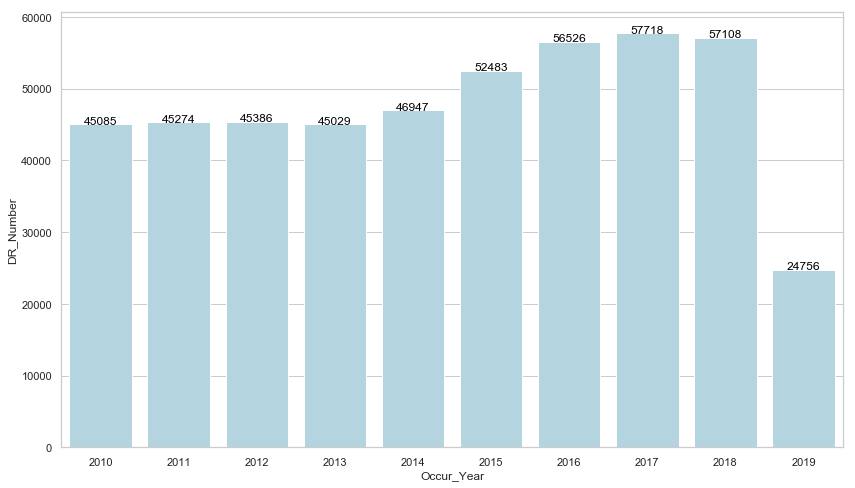

In [414]:
df_TotalPerYear = df_Full.groupby("Occur_Year").count()[["DR_Number"]].reset_index(["Occur_Year"])
f, ax = plt.subplots(figsize=(14,8))
sns.set(style="whitegrid")
showPlot = sns.barplot(data=df_TotalPerYear,x="Occur_Year",y="DR_Number",color="lightblue")
for index,values in df_TotalPerYear.iterrows():
    showPlot.text(values.name,values["DR_Number"],values["DR_Number"],color="black",ha="center")
plt.show()

It shows that
- The cases are raised up since 2010 - 2017/2018
- It increased rapidly from 2014->2015->2016

### 3.3.2- Total accident per month under each year
- due to the statistic for 2019 only have half year, it might be a disturb factor while doing anaylsis with the data, so split the case of 2019 from the data set

In [596]:
# Get all records expect 2019 data
df_TotalPerMonthUnderYear = df_Full.query("Occur_Year!='2019'")
# group data
df_TotalPerMonthUnderYear = df_TotalPerMonthUnderYear.groupby(["Occur_Month","Occur_Year"]).count()[["DR_Number"]]
# Get the dataframe 
df_TotalPerMonthUnderYear = df_TotalPerMonthUnderYear.reset_index()

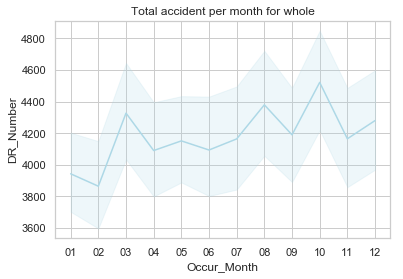

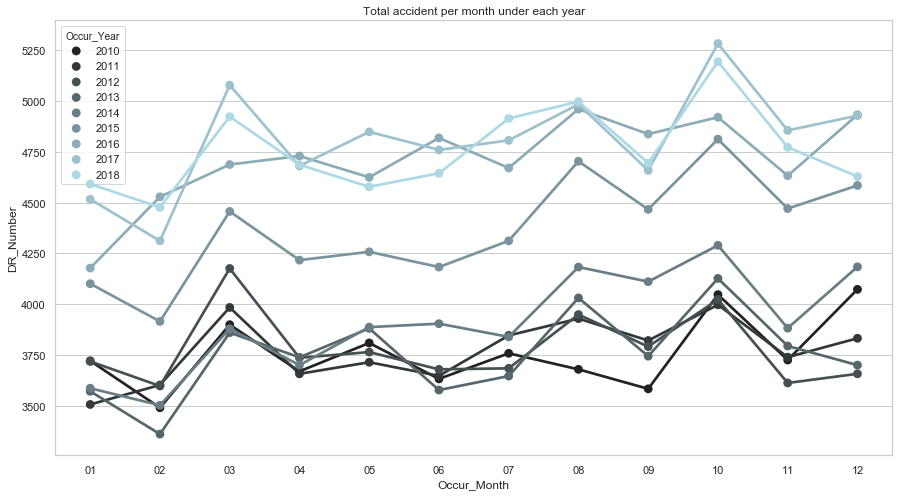

In [597]:
g2 = sns.lineplot(data=df_TotalPerMonthUnderYear,x="Occur_Month",y="DR_Number",color="lightblue")
g2.set_title("Total accident per month for whole")
plt.show()
f,ax = plt.subplots(figsize=(15,8))
g = sns.pointplot(data=df_TotalPerMonthUnderYear,x="Occur_Month",y="DR_Number",hue="Occur_Year",color="lightblue")
g.set_title("Total accident per month under each year")
plt.show()

- The accidents are increased on same month ervey year
- The accidents distributions on each month are similar, the Feb is minmun and the Oct is the maxmun for most years, it also shows the same trend on the top pic total accident per month for whole

### 3.3.3- Total accident per day group on each month

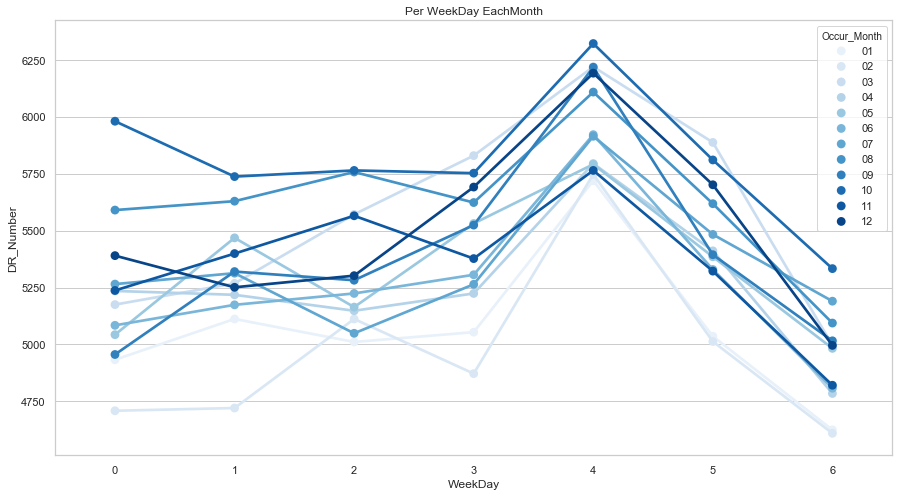

In [633]:
df_PerHourOnEachMonth = df_Full.query("Occur_Year != '2019'")
df_PerHourOnEachMonth = df_PerHourOnEachMonth.groupby(["WeekDay","Occur_Month"]).count()["DR_Number"]
df_PerHourOnEachMonth = df_PerHourOnEachMonth.reset_index()

f,ax = plt.subplots(figsize=(15,8))
g_perDay = sns.pointplot(data=df_PerHourOnEachMonth,x=df_PerHourOnEachMonth.WeekDay,y=df_PerHourOnEachMonth.DR_Number,
           hue=df_PerHourOnEachMonth.Occur_Month,palette="Blues")
g_perDay.set_title("Per WeekDay EachMonth")
plt.show()

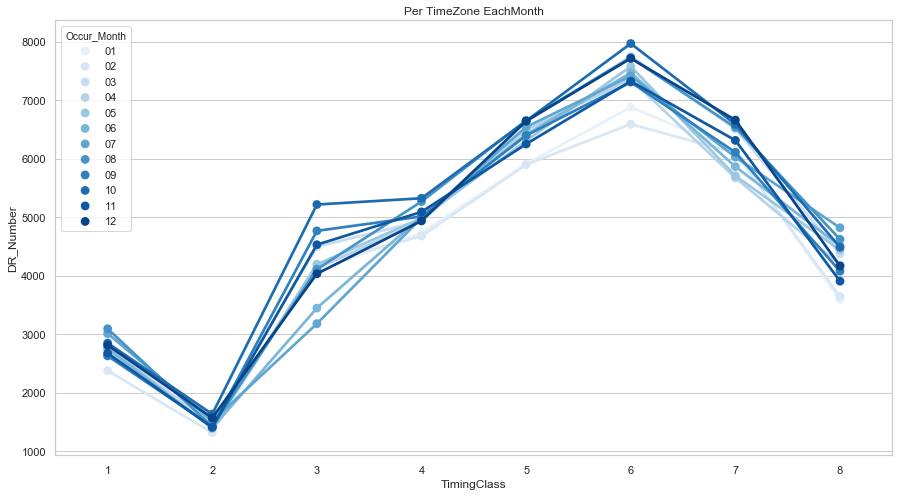

In [632]:
df_PerHourOnEachMonth = df_Full.query("Occur_Year != '2019'")
df_PerHourOnEachMonth = df_PerHourOnEachMonth.groupby(["TimingClass","Occur_Month"]).count()["DR_Number"]
df_PerHourOnEachMonth = df_PerHourOnEachMonth.reset_index()

f,ax = plt.subplots(figsize=(15,8))
g_perDay = sns.pointplot(data=df_PerHourOnEachMonth,x=df_PerHourOnEachMonth.TimingClass,y=df_PerHourOnEachMonth.DR_Number,
           hue=df_PerHourOnEachMonth.Occur_Month,palette="Blues")
g_perDay.set_title("Per TimeZone EachMonth")
plt.show()

Base on above pics:
- The minimum day is Sat and the maximum is Tue
- The minimum timezone is at 0300 - 0600 AM and the maximum is at 1800 - 2100 PM

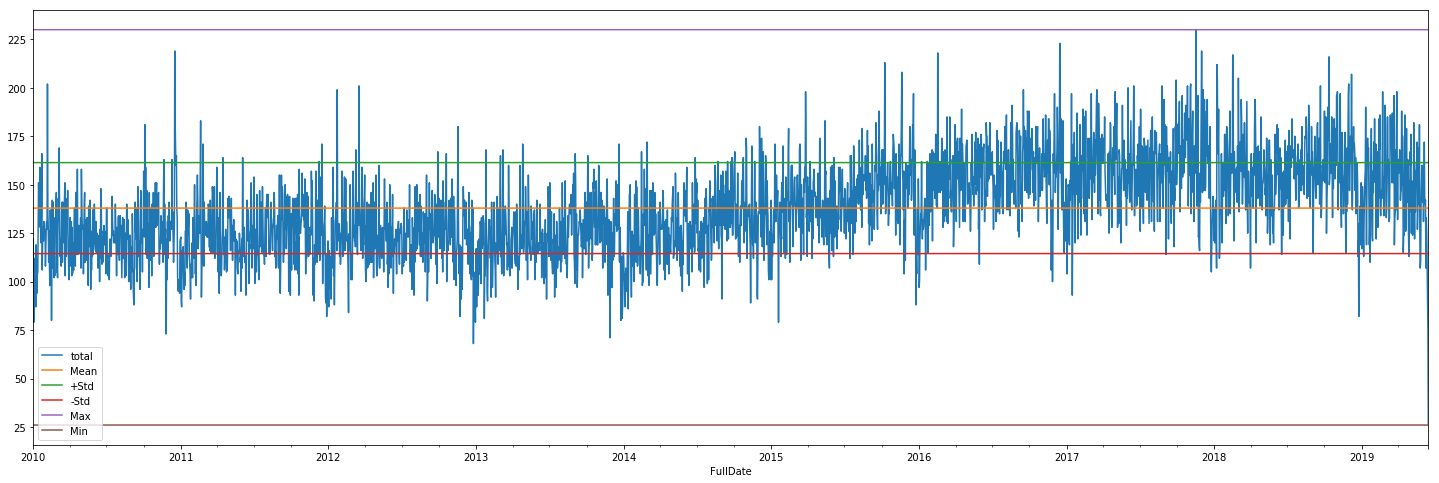

In [182]:
df_PerDay = pd.DataFrame(df_Full.resample("D").size())
df_PerDay = df_PerDay.rename(columns={0:"total"})
df_PerDay["Mean"] = df_Full.resample("D").size().mean()
df_PerDay["+Std"]=df_PerDay["Mean"] + df_Full.resample("D").size().std()
df_PerDay["-Std"]=df_PerDay["Mean"] - df_Full.resample("D").size().std()
df_PerDay["Max"]=df_Full.resample("D").size().max()
df_PerDay["Min"]=df_Full.resample("D").size().min()
df_PerDay.plot(figsize=(25,8),subplots=False)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001B530C9DE80>,
      dtype=object)

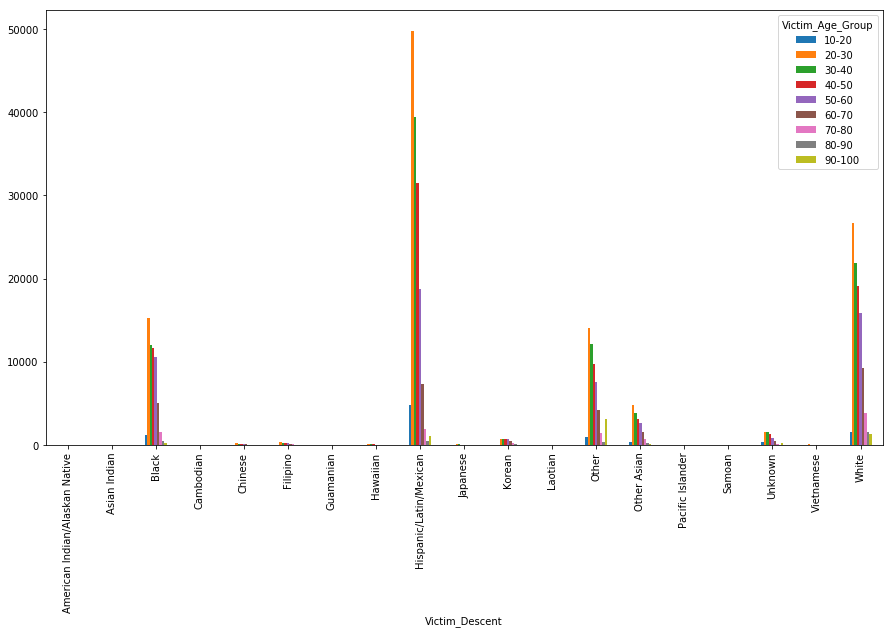

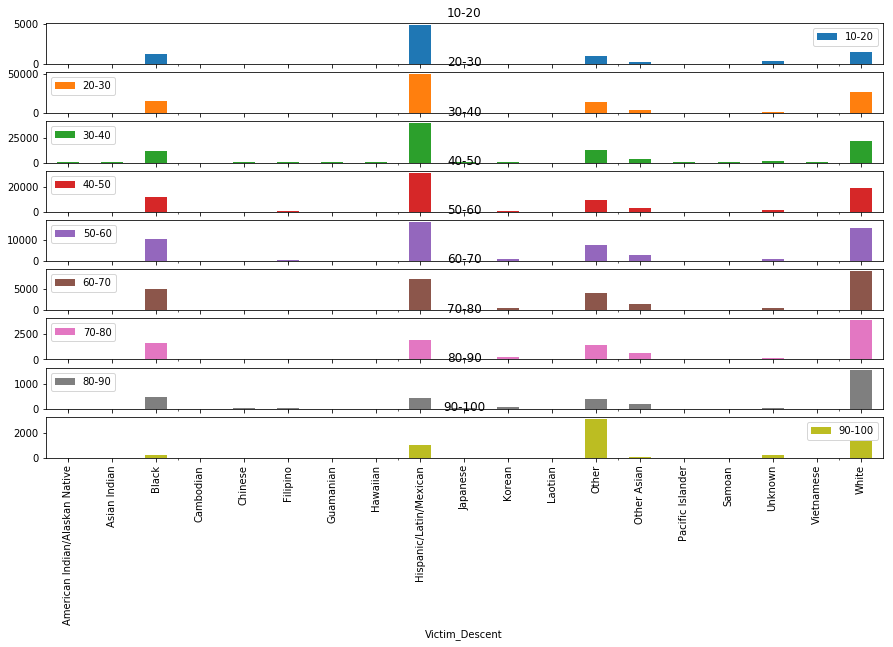

In [227]:
df_Full.pivot_table(index='Victim_Descent', 
                    columns='Victim_Age_Group', 
                    aggfunc='size').plot(subplots=False,figsize=(15,8),kind="bar")
df_Full.pivot_table(index='Victim_Descent', 
                    columns='Victim_Age_Group', 
                    aggfunc='size').plot(subplots=True,figsize=(15,8),kind="bar")